In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import os
import glob
import pickle

sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set_palette("deep")


# ONT Sequencing Multiplexing Comparison

This report presents a comparison of QC metrics between two Oxford Nanopore sequencing runs, to determine if multiplexing samples is a viable method for future sequencing runs, based on sequencing yields, quality of basecalling, alignment, and variant calling accuracy.

## Methods

### Data Processing

- **Basecalling**: [wf-basecalling v1.1.7](https://github.com/epi2me-labs/wf-basecalling/tree/v1.1.7)

  - Basecalled data located in `basecalled/`

- **Alignment and Variant Calling**: [wf-human-variation v2.1.0](https://github.com/epi2me-labs/wf-human-variation/tree/v2.1.0)
  - Aligned data and called variants located in `vcf/`

### Quality Control Tools

- **NanoPlot**: [1.42.0](https://quay.io/biocontainers/nanoplot:1.42.0--pyhdfd78af_0)

  - Generates summary statistics for each sample and creates visualizations of QC metrics for sequencing summaries and aligned BAM files.

- **NanoComp**: [1.23.1](https://quay.io/biocontainers/nanocomp:1.23.1--pyhdfd78af_0)

  - Compares multiple sequencing runs and generates comparative plots.

- **mosdepth**: [0.3.3](https://github.com/brentp/mosdepth/tree/v0.3.3)

  - Calculates sequencing depth across the human genome for each sample.

- **rtg-tools**: [3.12.1](https://github.com/RealTimeGenomics/rtg-tools/tree/3.12.1)

  - Performs performs variant comparison against a truth dataset.

### Data Organisation

The QC reports generated by NanoPlot are stored in the following directories:

- `qc/nanoplot/`

The NanoComp reports are stored in:

- `qc/nanocomp/`

The RTG Tools reports are stored in:

- `qc/variant_benchmark/`


## Results

Aggregate table of the QC metrics from NanoStats for both singleplexed and multiplexed samples, from the aligned `.cram` files produced by `wf-human-variation`.

Unless otherwise specified, subsequent plots and statistics include only samples basecalled with the `sup` algorithm.


In [27]:
aligned_bams_dir = "/scratch/prj/ppn_als_longread/qc/nanoplot/aligned_bams/"
seq_summaries_dir = "/scratch/prj/ppn_als_longread/qc/nanoplot/seq_summaries/"
suffixes = ["_sup", "_hac"]


def parse_nanostats(file_path):
    metrics = {}
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            if line.strip() and not line.startswith("Metrics dataset"):
                if line.startswith("Reads >Q"):
                    parts = line.split(":")
                    key = parts[0].strip()
                    values = parts[1].strip().split()
                    metrics[f"{key}_count"] = int(values[0].replace(",", ""))
                    metrics[f"{key}_percentage"] = float(values[1].strip("()%"))
                    metrics[f"{key}_bases"] = float(values[2].strip("Mb")) * 1e6
                else:
                    key, value = line.split(maxsplit=1)
                    metrics[key.strip()] = value.strip()
    return metrics


def determine_multiplexing(sample_name, seq_summaries_dir):
    for subdir in os.listdir(seq_summaries_dir):
        if sample_name in subdir:
            if "__" in subdir:
                return "multiplex"
            else:
                return "singleplex"
    return "unknown"


data = []

for subdir in os.listdir(aligned_bams_dir):
    for suffix in suffixes:
        if subdir.endswith(suffix):
            sample_name = subdir.split(suffix)[0]
            file_path = os.path.join(aligned_bams_dir, subdir, "NanoStats.txt")
            if os.path.isfile(file_path):
                metrics = parse_nanostats(file_path)
                metrics["sample"] = sample_name
                metrics["basecall"] = suffix.lstrip("_")
                metrics["multiplexing"] = determine_multiplexing(
                    sample_name, seq_summaries_dir
                )
                data.append(metrics)
            break

metrics_df = pd.DataFrame(data)

metrics_df.drop(columns=["Metrics"], inplace=True)

cols = ["sample", "basecall", "multiplexing"] + [
    col
    for col in metrics_df.columns
    if col not in ["sample", "basecall", "multiplexing"]
]

column_types = {
    "multiplexing": "category",
    "basecall": "category",
    "number_of_reads": "numeric",
    "number_of_bases": "numeric",
    "number_of_bases_aligned": "numeric",
    "fraction_bases_aligned": "numeric",
    "mean_read_length": "numeric",
    "median_read_length": "numeric",
    "read_length_stdev": "numeric",
    "n50": "numeric",
    "average_identity": "numeric",
    "Reads >Q5_count": "numeric",
    "Reads >Q5_percentage": "numeric",
    "Reads >Q5_bases": "numeric",
    "Reads >Q7_count": "numeric",
    "Reads >Q7_percentage": "numeric",
    "Reads >Q7_bases": "numeric",
    "Reads >Q10_count": "numeric",
    "Reads >Q10_percentage": "numeric",
    "Reads >Q10_bases": "numeric",
    "Reads >Q12_count": "numeric",
    "Reads >Q12_percentage": "numeric",
    "Reads >Q12_bases": "numeric",
    "Reads >Q15_count": "numeric",
    "Reads >Q15_percentage": "numeric",
    "Reads >Q15_bases": "numeric",
}

for column, dtype in column_types.items():
    if dtype == "category":
        metrics_df[column] = metrics_df[column].astype(dtype)
    elif dtype == "numeric":
        metrics_df[column] = pd.to_numeric(metrics_df[column])

metrics_df = metrics_df[cols]
metrics_df = metrics_df.sort_values(by=["multiplexing", "sample"])

metrics_df


,sample,basecall,multiplexing,number_of_reads,number_of_bases,number_of_bases_aligned,fraction_bases_aligned,median_read_length,mean_read_length,read_length_stdev,...,Reads >Q7_bases,Reads >Q10_count,Reads >Q10_percentage,Reads >Q10_bases,Reads >Q12_count,Reads >Q12_percentage,Reads >Q12_bases,Reads >Q15_count,Reads >Q15_percentage,Reads >Q15_bases
11,A046_12,hac,multiplex,4988817,3.302556e+10,3.095328e+10,0.9,4604.0,6619.9,6555.8,...,3.290220e+10,4673829,93.7,3.142930e+10,4141189,83.0,2.824520e+10,2929346,58.7,2.068870e+10
23,A046_12,sup,multiplex,4994494,3.315563e+10,3.103172e+10,0.9,4608.0,6638.4,6581.3,...,3.298270e+10,4853330,97.2,3.230140e+10,4574207,91.6,3.068470e+10,3809739,76.3,2.621910e+10
17,A048_09,hac,multiplex,7000239,3.951355e+10,3.683279e+10,0.9,2991.0,5644.6,6731.0,...,3.940030e+10,6542521,93.5,3.754860e+10,5708562,81.5,3.349920e+10,3753807,53.6,2.341970e+10
24,A048_09,sup,multiplex,7010703,3.966838e+10,3.693753e+10,0.9,2989.0,5658.3,6755.7,...,3.950570e+10,6825889,97.4,3.871450e+10,6393645,91.2,3.662560e+10,5175271,73.8,3.077650e+10
15,A079_07,hac,multiplex,3753588,3.071486e+10,2.930879e+10,1.0,5236.0,8182.8,8410.7,...,3.062940e+10,3546373,94.5,2.952060e+10,3153381,84.0,2.673710e+10,2156534,57.5,1.907640e+10
20,A079_07,sup,multiplex,3756616,3.082214e+10,2.937919e+10,1.0,5248.0,8204.8,8437.7,...,3.068520e+10,3656314,97.3,3.014920e+10,3458333,92.1,2.877880e+10,2877816,76.6,2.472000e+10
8,A081_91,sup,multiplex,3244516,2.530996e+10,2.396651e+10,0.9,4055.0,7800.8,9012.1,...,2.522810e+10,3162465,97.5,2.479730e+10,2979982,91.8,2.355710e+10,2449299,75.5,1.998420e+10
21,A081_91,hac,multiplex,3240730,2.521830e+10,2.390468e+10,0.9,4056.0,7781.7,8981.6,...,2.516040e+10,3053493,94.2,2.416910e+10,2703279,83.4,2.178240e+10,1817497,56.1,1.519910e+10
5,A085_00,sup,multiplex,3718011,2.703696e+10,2.542200e+10,0.9,4124.0,7271.9,8103.8,...,2.691270e+10,3585237,96.4,2.628950e+10,3320884,89.3,2.474070e+10,2614948,70.3,2.039480e+10
22,A085_00,hac,multiplex,3712771,2.694081e+10,2.534519e+10,0.9,4120.0,7256.3,8113.0,...,2.686030e+10,3424125,92.2,2.549680e+10,2931947,79.0,2.242090e+10,1856216,50.0,1.504290e+10


### Sequencing Yield

#### 1. Raw Yields


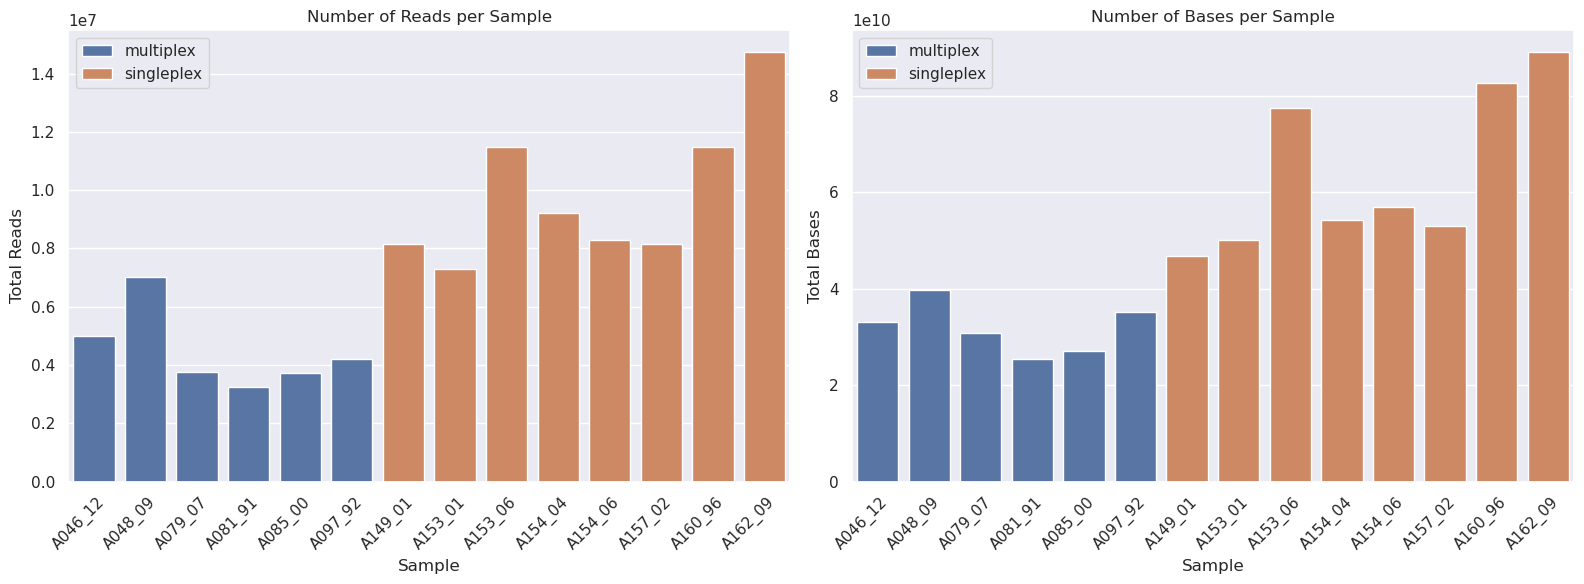

In [56]:
yields_df = metrics_df[metrics_df["basecall"] == "sup"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    x="sample",
    y="number_of_reads",
    hue="multiplexing",
    data=yields_df,
    ax=axes[0],
)
axes[0].set_title("Number of Reads per Sample")
axes[0].set_xlabel("Sample")
axes[0].set_ylabel("Total Reads")

locs, labels = axes[0].get_xticks(), axes[0].get_xticklabels()
locs = [loc - 0.3 for loc in locs]
axes[0].set_xticks(locs)
axes[0].set_xticklabels(labels, rotation=45)
axes[0].legend()

sns.barplot(
    x="sample",
    y="number_of_bases",
    hue="multiplexing",
    data=yields_df,
    ax=axes[1],
)
axes[1].set_title("Number of Bases per Sample")
axes[1].set_xlabel("Sample")
axes[1].set_ylabel("Total Bases")

locs, labels = axes[1].get_xticks(), axes[1].get_xticklabels()
locs = [loc - 0.3 for loc in locs]
axes[1].set_xticks(locs)
axes[1].set_xticklabels(labels, rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()


##### Summary Stats


In [4]:
singleplex_yields = metrics_df[
    (metrics_df["multiplexing"] == "singleplex") & (metrics_df["basecall"] == "sup")
]
multiplex_yields = metrics_df[
    (metrics_df["multiplexing"] == "multiplex") & (metrics_df["basecall"] == "sup")
]

singleplex_stats = {
    "max_reads": singleplex_yields["number_of_reads"].max(),
    "min_reads": singleplex_yields["number_of_reads"].min(),
    "mean_reads": singleplex_yields["number_of_reads"].mean(),
    "std_reads": singleplex_yields["number_of_reads"].std(),
    "max_bases": singleplex_yields["number_of_bases"].max(),
    "min_bases": singleplex_yields["number_of_bases"].min(),
    "mean_bases": singleplex_yields["number_of_bases"].mean(),
    "std_bases": singleplex_yields["number_of_bases"].std(),
}

print("Singleplexed Samples Stats:")
print(singleplex_stats)

multiplex_stats = {
    "max_reads": multiplex_yields["number_of_reads"].max(),
    "min_reads": multiplex_yields["number_of_reads"].min(),
    "mean_reads": multiplex_yields["number_of_reads"].mean(),
    "std_reads": multiplex_yields["number_of_reads"].std(),
    "max_bases": multiplex_yields["number_of_bases"].max(),
    "min_bases": multiplex_yields["number_of_bases"].min(),
    "mean_bases": multiplex_yields["number_of_bases"].mean(),
    "std_bases": multiplex_yields["number_of_bases"].std(),
}

print("\nMultiplexed Samples Stats:")
print(multiplex_stats)

percentage_increase_reads = (
    (singleplex_stats["mean_reads"] - multiplex_stats["mean_reads"])
    / multiplex_stats["mean_reads"]
) * 100

print(
    "\nPercentage Increase for Singleplexed Mean Number of Reads: {:.2f}%".format(
        percentage_increase_reads
    )
)

percentage_increase_bases = (
    (singleplex_stats["mean_bases"] - multiplex_stats["mean_bases"])
    / multiplex_stats["mean_bases"]
) * 100

print(
    "Percentage Increase for Singleplexed Mean Number of Bases: {:.2f}%".format(
        percentage_increase_bases
    )
)


Singleplexed Samples Stats:
{'max_reads': 14748981, 'min_reads': 7278922, 'mean_reads': 9852490.875, 'std_reads': 2520439.168097748, 'max_bases': 89066920475.0, 'min_bases': 46724841571.0, 'mean_bases': 63738789433.375, 'std_bases': 16558552544.923466}

Multiplexed Samples Stats:
{'max_reads': 7010703, 'min_reads': 3244516, 'mean_reads': 4490539.166666667, 'std_reads': 1368722.2865796285, 'max_bases': 39668379048.0, 'min_bases': 25309962961.0, 'mean_bases': 31845929047.833332, 'std_bases': 5296690497.76971}

Percentage Increase for Singleplexed Mean Number of Reads: 119.41%
Percentage Increase for Singleplexed Mean Number of Bases: 100.15%


- **Singleplexed**

  - For singleplexed samples, the number of reads ranges from 7.3 million to 14.7 million, with a mean yield of 9.9 million ± 2.5 million.
  - The number of bases ranges from 46.7 billion to 89.1 billion, with a mean yield of 63.7 billion ± 16.6 billion.

- **Multiplexed**
  - For multiplexed samples, the number of reads ranges from 3.2 million to 7.0 million, with a mean yield of 4.5 million ± 1.4 million.
  - The number of bases ranges from 25.3 billion to 39.7 billion, with a mean yield of 31.8 billion ± 5.3 billion.

On average, singleplexed sequencing resulted in a 119.41% increase in the number of reads and a 100.15% increase in the number of bases sequenced per sample.


#### 2. Read Lengths


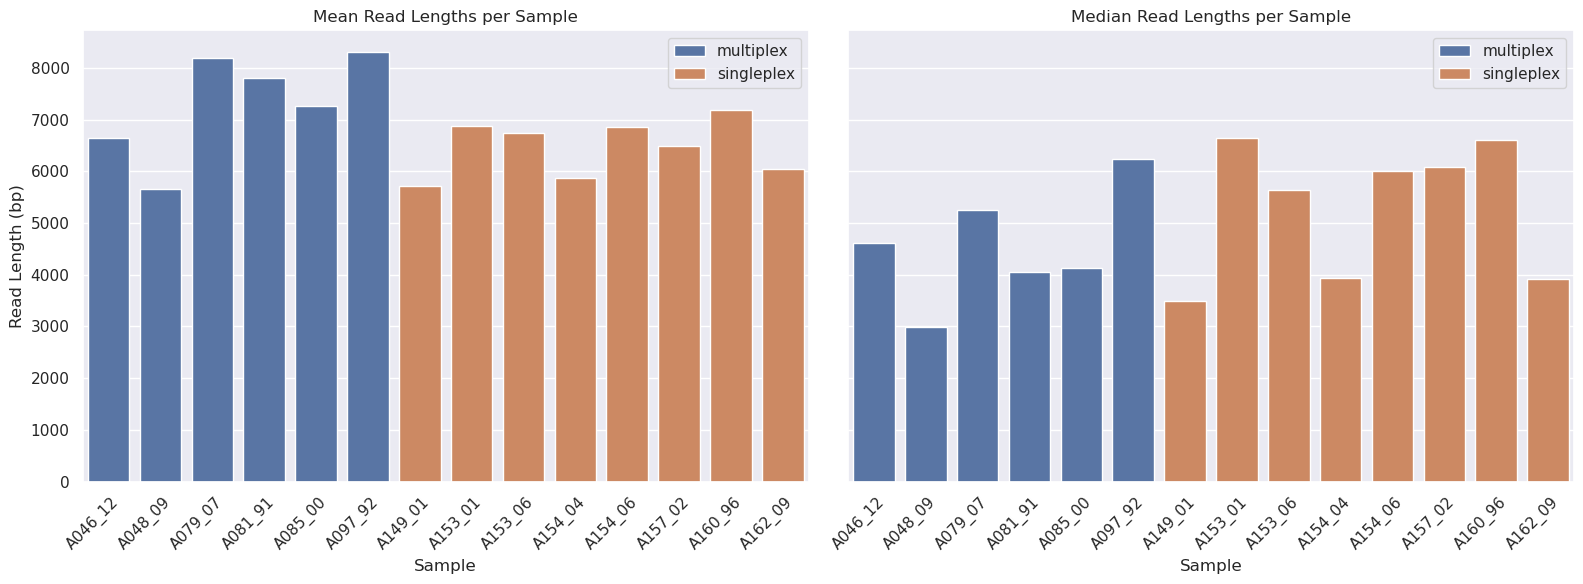

In [55]:
read_length_df = pd.melt(
    metrics_df[metrics_df["basecall"] == "sup"],
    id_vars=["sample", "multiplexing"],
    value_vars=["mean_read_length", "median_read_length"],
    var_name="read_length_type",
    value_name="read_length",
)

read_length_df["read_length_type"] = read_length_df["read_length_type"].replace(
    {"mean_read_length": "Mean Read Length", "median_read_length": "Median Read Length"}
)

mean_read_length_df = read_length_df[
    read_length_df["read_length_type"] == "Mean Read Length"
]
median_read_length_df = read_length_df[
    read_length_df["read_length_type"] == "Median Read Length"
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.barplot(
    x="sample",
    y="read_length",
    hue="multiplexing",
    data=mean_read_length_df,
    errorbar=None,
    ax=axes[0],
)
axes[0].set_title("Mean Read Lengths per Sample")
axes[0].set_xlabel("Sample")
axes[0].set_ylabel("Read Length (bp)")
locs, labels = axes[0].get_xticks(), axes[0].get_xticklabels()
locs = [loc - 0.3 for loc in locs]
axes[0].set_xticks(locs)
axes[0].set_xticklabels(labels, rotation=45)
axes[0].legend()

sns.barplot(
    x="sample",
    y="read_length",
    hue="multiplexing",
    data=median_read_length_df,
    errorbar=None,
    ax=axes[1],
)
axes[1].set_title("Median Read Lengths per Sample")
axes[1].set_xlabel("Sample")

locs, labels = axes[1].get_xticks(), axes[1].get_xticklabels()
locs = [loc - 0.3 for loc in locs]
axes[1].set_xticks(locs)
axes[1].set_xticklabels(labels, rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()


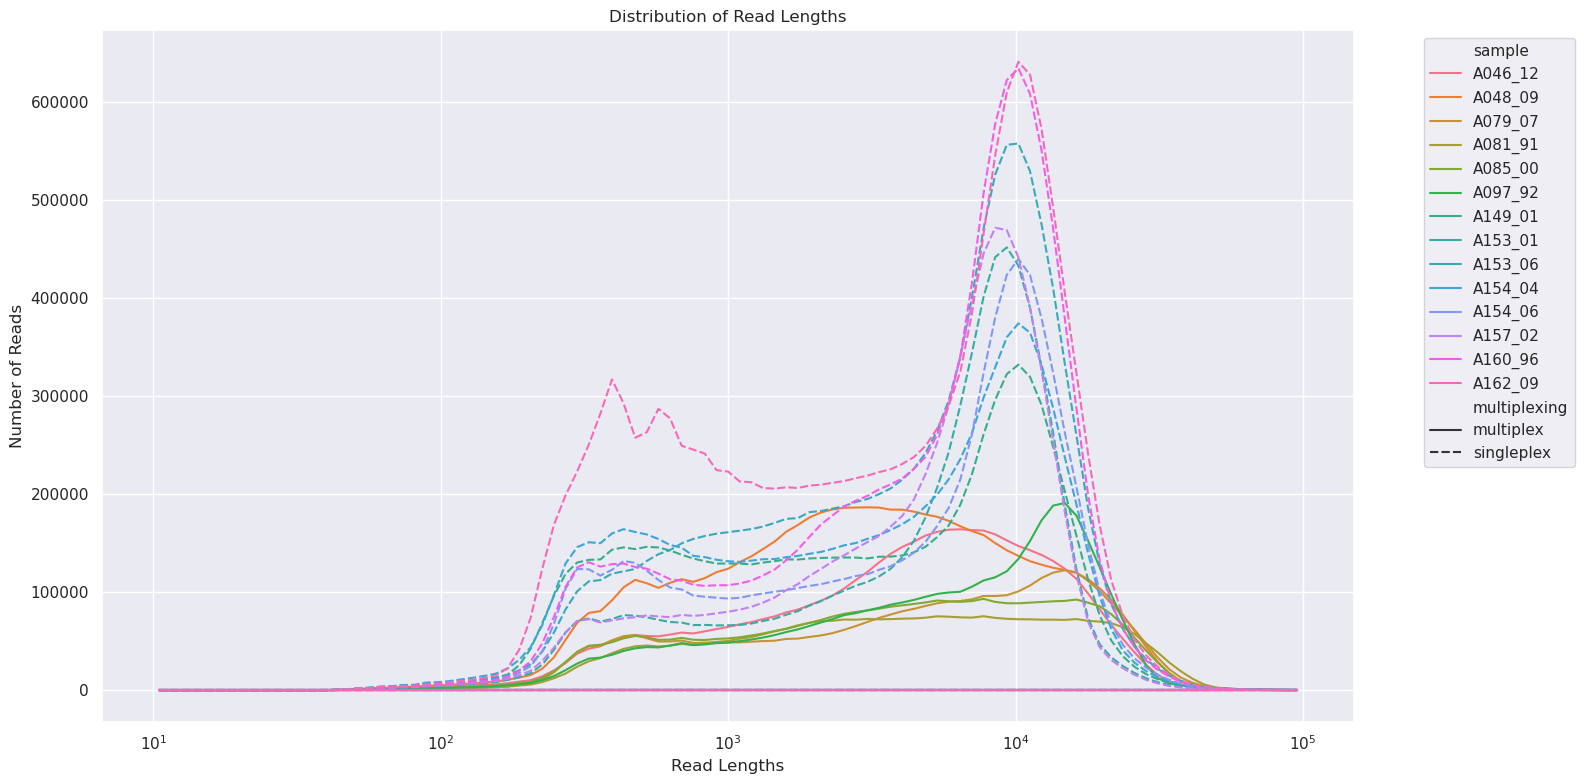

In [6]:
base_dir = "/scratch/prj/ppn_als_longread/qc/nanoplot/aligned_bams/"

all_quals = pd.DataFrame()

for _, row in metrics_df.iterrows():
    sample = row["sample"]
    basecall = row["basecall"]
    suffix = f"_{basecall}"
    sample_dir = f"{sample}{suffix}"
    pickle_path = os.path.join(base_dir, sample_dir, "NanoPlot-data.pickle")

    if os.path.isfile(pickle_path):
        with open(pickle_path, "rb") as file:
            nanoplot_data = pickle.load(file)
        pickle_df = pd.DataFrame(nanoplot_data)
        sample_quals = pickle_df[["readIDs", "quals", "lengths", "mapQ"]].copy()
        sample_quals["sample"] = sample
        sample_quals["basecall"] = basecall
        all_quals = pd.concat([all_quals, sample_quals], ignore_index=True)

all_quals = all_quals.merge(
    metrics_df[["sample", "multiplexing", "basecall"]], on=["sample", "basecall"]
)

bin_edges = np.logspace(np.log10(10), np.log10(1e5), num=100)
all_quals["length_bin"] = pd.cut(all_quals["lengths"], bins=bin_edges)

length_counts = (
    all_quals[all_quals["basecall"] == "sup"]
    .groupby(["sample", "length_bin", "multiplexing"], observed=False)
    .size()
    .reset_index(name="count")
)

bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
bin_centers = pd.Series(bin_centers, index=length_counts["length_bin"].cat.categories)
length_counts["bin_center"] = length_counts["length_bin"].map(bin_centers)

plt.figure(figsize=(16, 8))

sns.lineplot(
    data=length_counts,
    x="bin_center",
    y="count",
    hue="sample",
    style="multiplexing",
)

plt.xscale("log")
plt.xlabel("Read Lengths")
plt.ylabel("Number of Reads")
plt.title("Distribution of Read Lengths")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


##### Summary Stats


In [7]:
singleplexed_quals = all_quals[
    (all_quals["multiplexing"] == "singleplex") & (all_quals["basecall"] == "sup")
]
multiplexed_quals = all_quals[
    (all_quals["multiplexing"] == "multiplex") & (all_quals["basecall"] == "sup")
]

singleplex_length_stats = {
    "max_length": singleplexed_quals["lengths"].max(),
    "min_length": singleplexed_quals["lengths"].min(),
    "mean_length": singleplexed_quals["lengths"].mean(),
    "std_length": singleplexed_quals["lengths"].std(),
    "median_length": singleplexed_quals["lengths"].median(),
}

print(f"Singleplexed Samples Stats: {singleplex_length_stats}")

multiplex_length_stats = {
    "max_length": multiplexed_quals["lengths"].max(),
    "min_length": multiplexed_quals["lengths"].min(),
    "mean_length": multiplexed_quals["lengths"].mean(),
    "std_length": multiplexed_quals["lengths"].std(),
    "median_length": multiplexed_quals["lengths"].median(),
}

print(f"\nMultiplexed Samples Stats: {multiplex_length_stats}")

percentage_increase_mean_length = (
    (singleplex_length_stats["mean_length"] - multiplex_length_stats["mean_length"])
    / multiplex_length_stats["mean_length"]
) * 100

print(
    f"\nPercentage Increase for Mean Read Length: {percentage_increase_mean_length:.2f}"
)

percentage_increase_median_length = (
    (singleplex_length_stats["median_length"] - multiplex_length_stats["median_length"])
    / multiplex_length_stats["median_length"]
) * 100

print(
    f"Percentage Increase for Median Read Length: {percentage_increase_median_length:.2f}"
)


Singleplexed Samples Stats: {'max_length': 771991, 'min_length': 40, 'mean_length': 6469.307126699065, 'std_length': 6119.115301814011, 'median_length': 5341.0}

Multiplexed Samples Stats: {'max_length': 290839, 'min_length': 40, 'mean_length': 7091.782938722837, 'std_length': 7657.740989959704, 'median_length': 4224.0}

Percentage Increase for Mean Read Length: -8.78
Percentage Increase for Median Read Length: 26.44


- **Singleplexed**

  - For singleplexed samples, the read length ranges from 40 bp to 771,991 bp, with a mean length of 6,469 bp ± 6,119 bp and a median length of 5,341 bp.
  - The distribution of read lengths in singleplexed samples shows two distinct peaks at approximately 10<sup>2.5</sup> (316 bp) and 10<sup>4</sup> (10,000 bp), indicating a significant presence of both shorter and longer reads. The higher median length suggests that a substantial portion of reads are relatively long, pulling the median value upwards, however, the presence of a considerable number of shorter reads lowers the mean read length.

- **Multiplexed**
  - For multiplexed samples, the read length ranges from 40 bp to 290,839 bp, with a mean length of 7,092 bp ± 7,658 bp and a median length of 4,224 bp.
  - The distributions of read lengths in multiplexed samples exhibit a more uniform distribution, with bimodal peaks less pronounced as those observed in singleplexed samples. The lower median length indicates that the central tendency of the read lengths is closer to the shorter end, although with a more consistent distribution.

On average, singleplexed sequencing resulted in an 8.78% decrease in the mean read length but a 26.44% increase in the median read length compared to multiplexed sequencing.


### Read Quality

#### Basecalling Quality


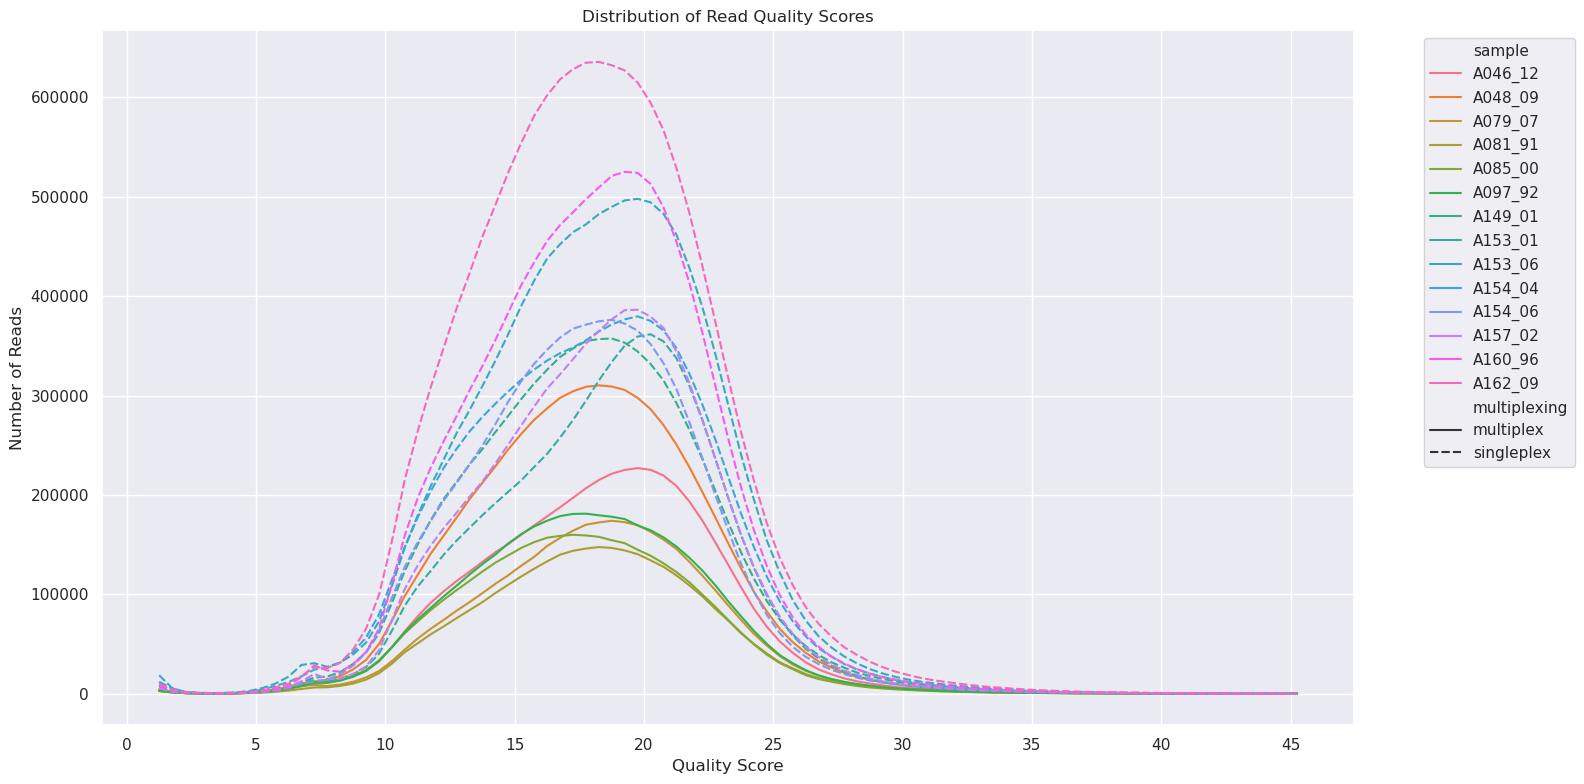

In [8]:
all_quals["quals_bin"] = pd.cut(
    all_quals["quals"],
    bins=pd.interval_range(
        start=all_quals["quals"].min(), end=all_quals["quals"].max(), freq=0.5
    ),
)

quality_distribution = (
    all_quals[all_quals["basecall"] == "sup"]
    .groupby(["sample", "quals_bin", "multiplexing"], observed=True)
    .size()
    .reset_index(name="count")
)

quality_distribution["quals_bin_mid"] = quality_distribution["quals_bin"].apply(
    lambda x: x.mid
)

plt.figure(figsize=(16, 8))

sns.lineplot(
    data=quality_distribution,
    x="quals_bin_mid",
    y="count",
    hue="sample",
    style="multiplexing",
)

plt.xlabel("Quality Score")
plt.ylabel("Number of Reads")
plt.title("Distribution of Read Quality Scores")

max_qual = int(all_quals["quals"].max())
tick_positions = np.arange(0, max_qual + 1, 5)
plt.xticks(ticks=tick_positions, labels=tick_positions)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


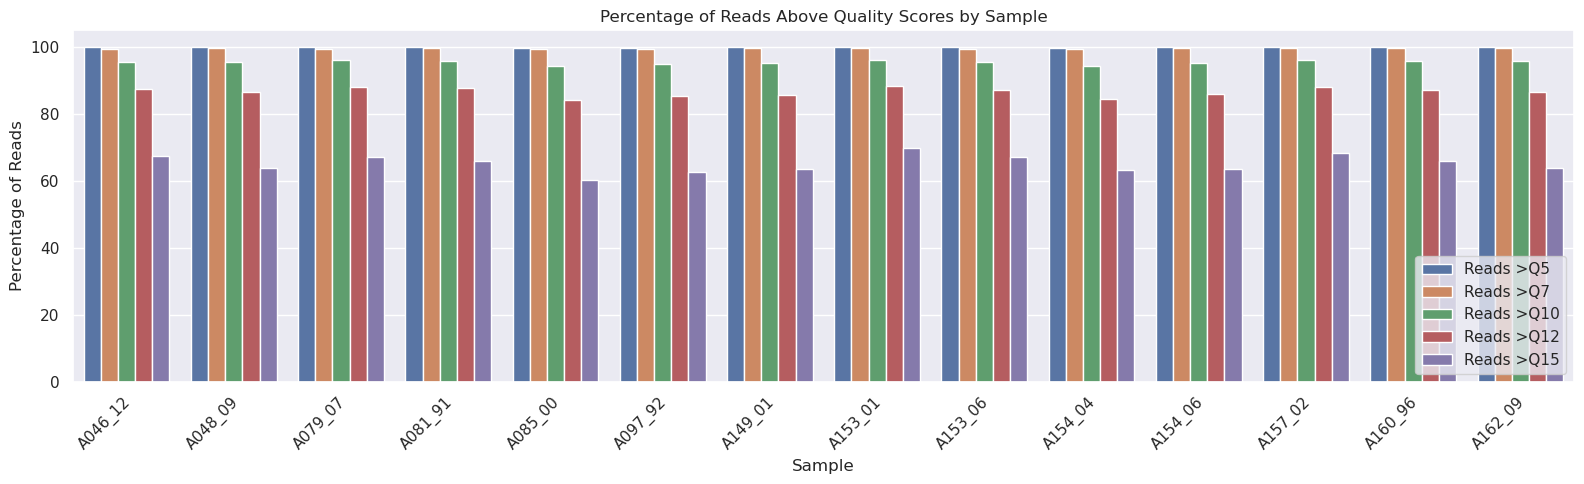

In [9]:
qscore_df = metrics_df.melt(
    id_vars="sample",
    value_vars=[
        "Reads >Q5_percentage",
        "Reads >Q7_percentage",
        "Reads >Q10_percentage",
        "Reads >Q12_percentage",
        "Reads >Q15_percentage",
    ],
    var_name="Quality_Score",
    value_name="Percentage",
)

qscore_df["Quality_Score"] = qscore_df["Quality_Score"].str.replace("_percentage", "")

plt.figure(figsize=(16, 5))

sns.barplot(
    data=qscore_df, x="sample", y="Percentage", hue="Quality_Score", errorbar=None
)

plt.xlabel("Sample")
plt.ylabel("Percentage of Reads")
plt.title("Percentage of Reads Above Quality Scores by Sample")
plt.legend(loc="lower right")
locs, labels = plt.xticks()
locs = [loc - 0.2 for loc in locs]
plt.xticks(locs, labels, rotation=45)
plt.tight_layout()
plt.show()


##### Summary Stats


In [10]:
singleplex_basequal_stats = {
    "max_quality": singleplexed_quals["quals"].max(),
    "min_quality": singleplexed_quals["quals"].min(),
    "mean_quality": singleplexed_quals["quals"].mean(),
    "std_quality": singleplexed_quals["quals"].std(),
    "median_quality": singleplexed_quals["quals"].median(),
}

print("Singleplexed Samples Quality Stats:")
print(singleplex_basequal_stats)

multiplex_basequal_stats = {
    "max_quality": multiplexed_quals["quals"].max(),
    "min_quality": multiplexed_quals["quals"].min(),
    "mean_quality": multiplexed_quals["quals"].mean(),
    "std_quality": multiplexed_quals["quals"].std(),
    "median_quality": multiplexed_quals["quals"].median(),
}

print("\nMultiplexed Samples Quality Stats:")
print(multiplex_basequal_stats)

percentage_increase_mean_quality = (
    (
        singleplex_basequal_stats["mean_quality"]
        - multiplex_basequal_stats["mean_quality"]
    )
    / multiplex_basequal_stats["mean_quality"]
) * 100

print(
    "\nPercentage Increase for Mean Basecalling Quality: {:.2f}%".format(
        percentage_increase_mean_quality
    )
)

percentage_increase_median_quality = (
    (
        singleplex_basequal_stats["median_quality"]
        - multiplex_basequal_stats["median_quality"]
    )
    / multiplex_basequal_stats["median_quality"]
) * 100

print(
    "\nPercentage Increase for Median Basecalling Quality: {:.2f}%".format(
        percentage_increase_median_quality
    )
)


Singleplexed Samples Quality Stats:
{'max_quality': 45.835899353027344, 'min_quality': 1.0, 'mean_quality': 18.034538873512496, 'std_quality': 4.440334895709509, 'median_quality': 18.13520622253418}

Multiplexed Samples Quality Stats:
{'max_quality': 45.741249084472656, 'min_quality': 1.0, 'mean_quality': 17.95788926342389, 'std_quality': 4.443302661515017, 'median_quality': 17.999780654907227}

Percentage Increase for Mean Basecalling Quality: 0.43%

Percentage Increase for Median Basecalling Quality: 0.75%


- **Read Quality Scores**

  - The mean quality score for singleplexed samples is 18.03 ± 4.44, which is slightly higher by 0.43% compared to the mean quality score of 17.96 for multiplexed samples.
  - The median quality score for singleplexed samples is 18.14, which is 0.75% higher than the median quality score of 18.00 for multiplexed samples.
  - This suggests marginally better overall read quality compared to multiplexed samples.

- **Reads Above Quality Score Thresholds**
  - All samples have a high percentage of reads with quality scores above 10, 12, and 15, consistently above 60%.
  - There are no significant differences in the percentage of high-quality reads between singleplexed and multiplexed samples across the quality thresholds.


#### Alignment Quality


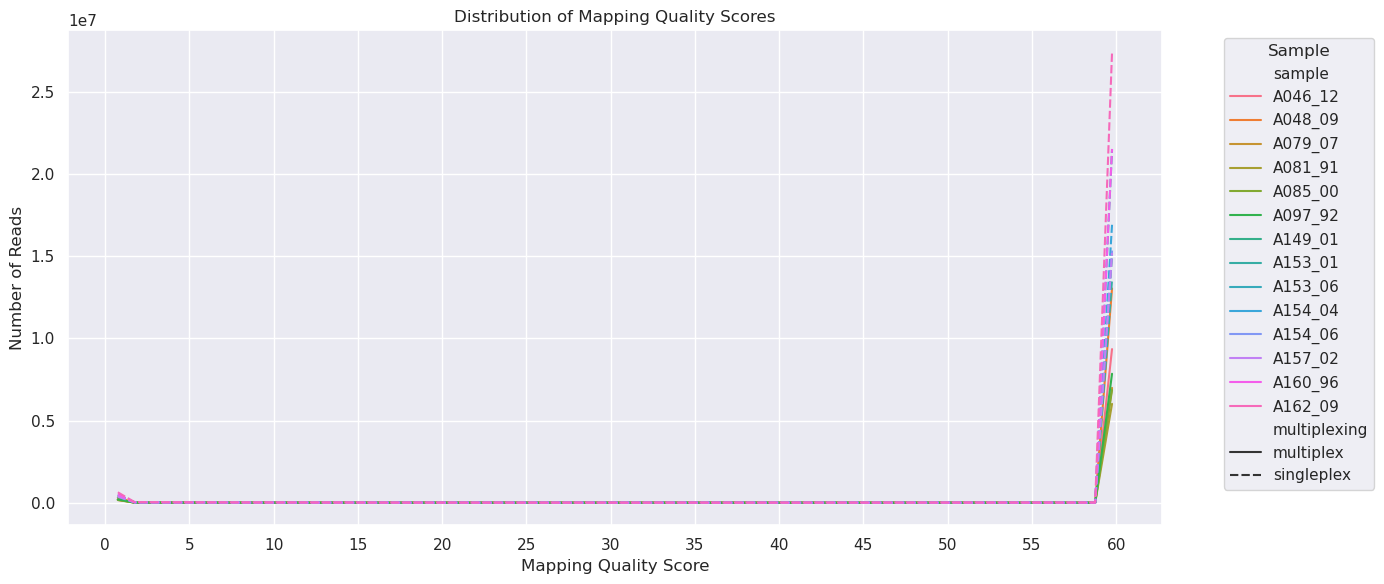

In [40]:
all_quals["mapQ_bin"] = pd.cut(
    all_quals["mapQ"],
    bins=pd.interval_range(
        start=all_quals["mapQ"].min(), end=all_quals["mapQ"].max(), freq=0.5
    ),
)

mapping_quality_distribution = (
    all_quals.groupby(["sample", "mapQ_bin", "multiplexing"], observed=True)
    .size()
    .reset_index(name="count")
)

mapping_quality_distribution["mapQ_bin_mid"] = mapping_quality_distribution[
    "mapQ_bin"
].apply(lambda x: x.mid)

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=mapping_quality_distribution,
    x="mapQ_bin_mid",
    y="count",
    hue="sample",
    style="multiplexing",
    legend="full",
)

plt.xlabel("Mapping Quality Score")
plt.ylabel("Number of Reads")
plt.title("Distribution of Mapping Quality Scores")

max_mapQ = int(all_quals["mapQ"].max())
tick_positions = np.arange(0, max_mapQ + 1, 5)
plt.xticks(ticks=tick_positions, labels=tick_positions)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


##### Summary Stats


In [13]:
singleplex_mapQ_stats = {
    "max_mapQ": singleplexed_quals["mapQ"].max(),
    "min_mapQ": singleplexed_quals["mapQ"].min(),
    "mean_mapQ": singleplexed_quals["mapQ"].mean(),
    "std_mapQ": singleplexed_quals["mapQ"].std(),
    "median_mapQ": singleplexed_quals["mapQ"].median(),
}

print("Singleplexed Samples Mapping Quality Stats:")
print(singleplex_mapQ_stats)

multiplex_mapQ_stats = {
    "max_mapQ": multiplexed_quals["mapQ"].max(),
    "min_mapQ": multiplexed_quals["mapQ"].min(),
    "mean_mapQ": multiplexed_quals["mapQ"].mean(),
    "std_mapQ": multiplexed_quals["mapQ"].std(),
    "median_mapQ": multiplexed_quals["mapQ"].median(),
}

print("\nMultiplexed Samples Mapping Quality Stats:")
print(multiplex_mapQ_stats)

percentage_increase_mean_mapQ = (
    (singleplex_mapQ_stats["mean_mapQ"] - multiplex_mapQ_stats["mean_mapQ"])
    / multiplex_mapQ_stats["mean_mapQ"]
) * 100

print(
    "\nPercentage Increase for Mean Mapping Quality: {:.2f}%".format(
        percentage_increase_mean_mapQ
    )
)

percentage_increase_median_mapQ = (
    (singleplex_mapQ_stats["median_mapQ"] - multiplex_mapQ_stats["median_mapQ"])
    / multiplex_mapQ_stats["median_mapQ"]
) * 100


print(
    "\nPercentage Increase for Median Mapping Quality: {:.2f}%".format(
        percentage_increase_median_mapQ
    )
)


Singleplexed Samples Mapping Quality Stats:
{'max_mapQ': 60, 'min_mapQ': 0, 'mean_mapQ': 56.98792545189746, 'std_mapQ': 12.156729392437006, 'median_mapQ': 60.0}

Multiplexed Samples Mapping Quality Stats:
{'max_mapQ': 60, 'min_mapQ': 0, 'mean_mapQ': 56.98456840835928, 'std_mapQ': 12.195534852039403, 'median_mapQ': 60.0}

Percentage Increase for Mean Mapping Quality: 0.01%

Percentage Increase for Median Mapping Quality: 0.00%


- **Mapping Quality Scores**
  - The mean mapping quality score for singleplexed samples is 56.99 ± 12.16, which is nearly identical to the mean mapping quality score of 56.98 for multiplexed samples, showing only a 0.01% increase.
  - The median mapping quality score for both singleplexed and multiplexed samples is 60.0, indicating no difference in the central tendency of mapping quality between the two methods.
  - This suggests that there is no significant difference in the overall mapping quality between singleplexed and multiplexed samples.


### Sequencing Depth


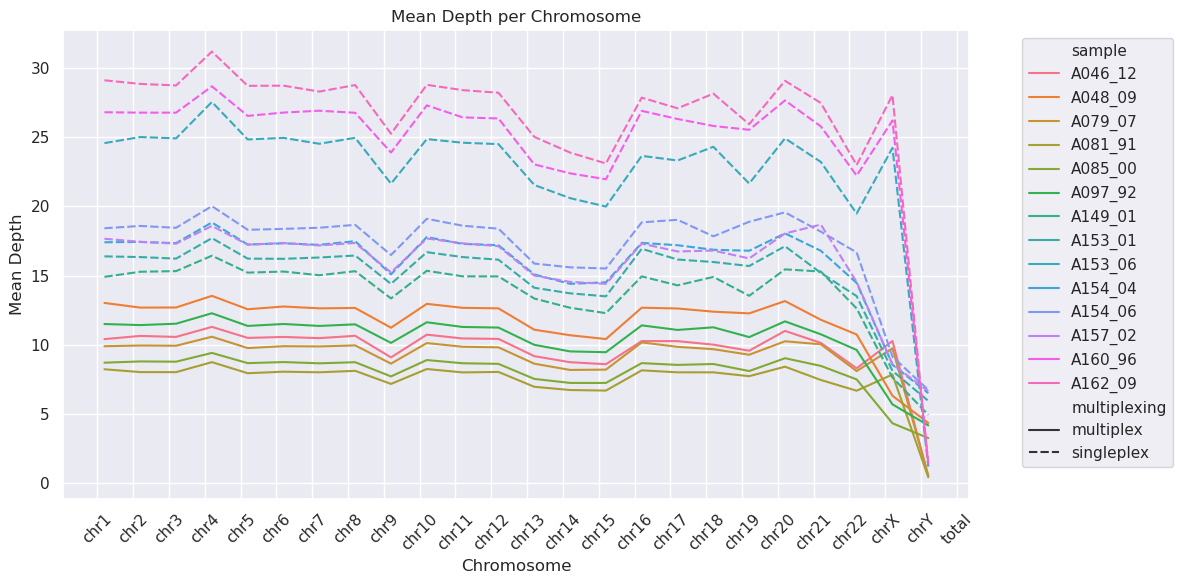

In [52]:
path_to_mosdepth = (
    f"/scratch/prj/ppn_als_longread/vcf/*{suffix}/*{suffix}.mosdepth.summary.txt"
)

mosdepth_files = glob.glob(path_to_mosdepth)


def process_mosdepth_file(file_path):
    sample_name = os.path.basename(file_path).split(".")[0].replace(suffix, "")

    df = pd.read_csv(file_path, sep="\t")

    chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY", "total"]

    df = df[df["chrom"].isin(chromosomes)]
    df = df[~df["chrom"].str.endswith("_region")]
    df = df[["chrom", "mean"]]
    df["sample"] = sample_name

    return df


all_dfs = [process_mosdepth_file(file) for file in mosdepth_files]
depth_df = pd.concat(all_dfs)

chromosome_order = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY", "total"]

depth_df["chrom"] = pd.Categorical(
    depth_df["chrom"], categories=chromosome_order, ordered=True
)

depth_df = depth_df.merge(
    metrics_df[["sample", "multiplexing"]], on="sample", how="left"
)

depth_df = depth_df.drop_duplicates(subset=["chrom", "sample"]).sort_values(
    by=["sample", "multiplexing"]
)

plt.figure(figsize=(12, 6))

wg_depth_df = depth_df[depth_df["chrom"] != "total"]

sns.lineplot(
    data=wg_depth_df,
    x="chrom",
    y="mean",
    hue="sample",
    style="multiplexing",
    legend="full",
)

plt.title("Mean Depth per Chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Mean Depth")
locs, labels = plt.xticks()
locs = [loc - 0.2 for loc in locs]
plt.xticks(locs, labels, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


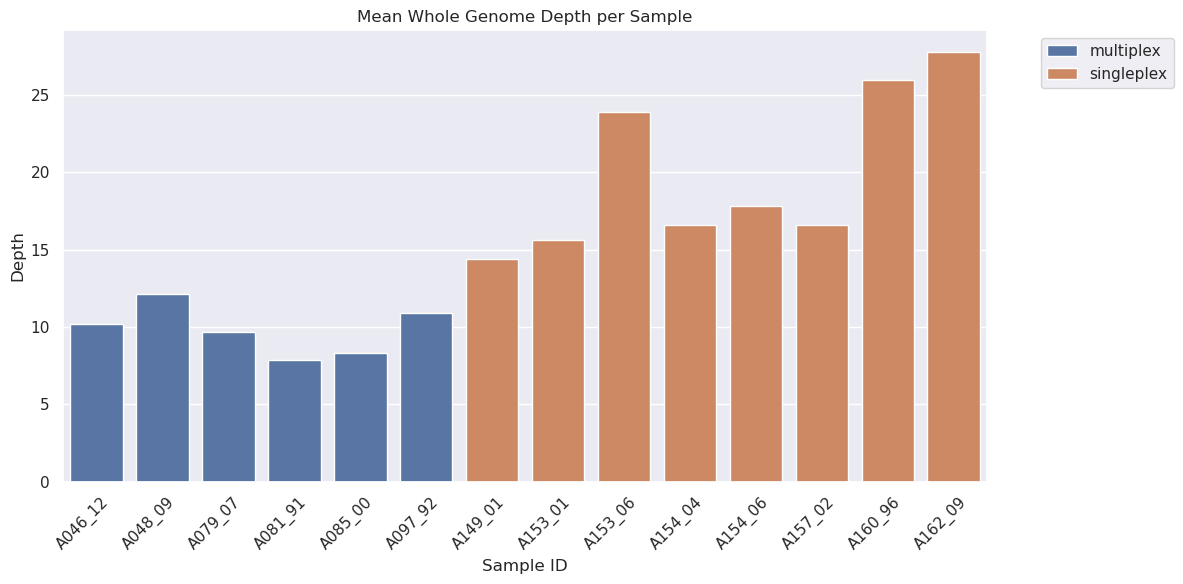

In [57]:
total_depth_df = depth_df[depth_df["chrom"] == "total"].copy()
total_depth_df = total_depth_df[["sample", "mean"]]

total_depth_df = total_depth_df.merge(
    metrics_df[["sample", "multiplexing"]], on="sample"
)

total_depth_df = total_depth_df.sort_values(by=["multiplexing", "sample"])

plt.figure(figsize=(12, 6))

sns.barplot(
    data=total_depth_df,
    x="sample",
    y="mean",
    hue="multiplexing",
    dodge=False,
)

plt.title("Mean Whole Genome Depth per Sample")
plt.xlabel("Sample ID")
plt.ylabel("Depth")
locs, labels = plt.xticks()
locs = [loc - 0.2 for loc in locs]
plt.xticks(locs, labels, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


##### Summary Stats


In [59]:
singleplexed_depth = total_depth_df[total_depth_df["multiplexing"] == "singleplex"]
multiplexed_depth = total_depth_df[total_depth_df["multiplexing"] == "multiplex"]

singleplex_stats = {
    "max_depth": singleplexed_depth["mean"].max(),
    "min_depth": singleplexed_depth["mean"].min(),
    "mean_depth": singleplexed_depth["mean"].mean(),
    "std_depth": singleplexed_depth["mean"].std(),
    "median_depth": singleplexed_depth["mean"].median(),
}

multiplex_stats = {
    "max_depth": multiplexed_depth["mean"].max(),
    "min_depth": multiplexed_depth["mean"].min(),
    "mean_depth": multiplexed_depth["mean"].mean(),
    "std_depth": multiplexed_depth["mean"].std(),
    "median_depth": multiplexed_depth["mean"].median(),
}

percentage_increase_depth = (
    (singleplex_stats["mean_depth"] - multiplex_stats["mean_depth"])
    / multiplex_stats["mean_depth"]
) * 100

print("Singleplexed Samples Stats:")
print(singleplex_stats)

print("\nMultiplexed Samples Stats:")
print(multiplex_stats)

print(
    "\nPercentage Increase for Mean Whole Genome Depth: {:.2f}%".format(
        percentage_increase_depth
    )
)


Singleplexed Samples Stats:
{'max_depth': 27.81, 'min_depth': 14.421, 'mean_depth': 19.846249999999998, 'std_depth': 5.040634159838753, 'median_depth': 17.2055}

Multiplexed Samples Stats:
{'max_depth': 12.114, 'min_depth': 7.858, 'mean_depth': 9.839166666666666, 'std_depth': 1.512554181348606, 'median_depth': 9.923}

Percentage Increase for Mean Whole Genome Depth: 101.71%


- **Singleplexed**

  - The mean whole genome depth for singleplexed samples ranges from 14.42 to 27.81, with an average depth of 19.85 ± 5.04.
  - The variability in depth among singleplexed samples is relatively high, indicating some inconsistency in the sequencing depth across different samples.

- **Multiplexed**
  - The mean whole genome depth for multiplexed samples ranges from 7.86 to 12.11, with an average depth of 9.84 ± 1.51.
  - A more consistent sequencing depth across these samples, indicated by the lower standard deviation.

The singleplexed samples exhibit a higher mean whole genome depth than multiplexed samples, with a percentage increase of 101.71%, indicating that singleplexing significantly enhances the depth of coverage.


### Variant Calling

Using RTG tools I measured the performance of variant calling performance for SNPs and indels between the ONT variants as the query dataset and Illumina variants as the truth dataset.

The aim is to establish:

1. Establish the overall performance of small variant calling in ONT (using Clair3).
1. Differences in variant calling performance between sequenced samples that were singleplexed vs multiplexed.
1. Differences in performance between basecalling algorithms.

I loaded all the summary files from RTG Tools vcfeval into a pandas dataframe for the comparison.
I retained only the rows without a quality threshold to reflect the entire VCF files.


In [39]:
base_dir = "/scratch/prj/ppn_als_longread/qc/variant_benchmark/"

df_list = []

for sample_dir in glob.glob(os.path.join(base_dir, "*/")):
    summary_file = os.path.join(sample_dir, "summary.txt")
    if os.path.isfile(summary_file):
        sample_df = pd.read_csv(
            summary_file,
            sep=r"\s+",
            skiprows=2,
            names=[
                "Threshold",
                "True-pos-baseline",
                "True-pos-call",
                "False-pos",
                "False-neg",
                "Precision",
                "Sensitivity",
                "F-measure",
            ],
        )
        sample_name = os.path.basename(os.path.dirname(sample_dir))
        sample_df["SampleName"] = sample_name
        df_list.append(sample_df)

all_data_df = pd.concat(df_list, ignore_index=True)

all_data_df[["sample", "basecall", "variant_type"]] = all_data_df[
    "SampleName"
].str.extract(r"(.+)_([^_]+)_(.+)$")

cols = ["sample", "basecall", "variant_type"] + [
    col
    for col in all_data_df.columns
    if col not in ["SampleName", "sample", "basecall", "variant_type"]
]
all_data_df = all_data_df[cols]

all_data_df = all_data_df[all_data_df["Threshold"].isna()]


def aggregate_stats(df, group_cols):
    return df.groupby(group_cols, observed=False).agg(
        {
            "Precision": ["mean", "std", "median"],
            "Sensitivity": ["mean", "std", "median"],
            "F-measure": ["mean", "std", "median"],
        }
    )


merged_df = pd.merge(all_data_df, metrics_df[["sample", "multiplexing"]], on="sample")
grouped = aggregate_stats(merged_df, ["basecall", "variant_type", "multiplexing"])
grouped.columns = ["_".join(col) for col in grouped.columns]
grouped.reset_index(inplace=True)

combined = merged_df.groupby(["variant_type", "multiplexing"], observed=False).agg(
    {
        "Precision": ["mean", "std", "median"],
        "Sensitivity": ["mean", "std", "median"],
        "F-measure": ["mean", "std", "median"],
    }
)

combined.columns = ["_".join(col) for col in combined.columns]
combined.reset_index(inplace=True)
combined["basecall"] = "combined"
final_grouped = pd.concat([grouped, combined], ignore_index=True)

both_multiplexing_combined = merged_df.groupby(
    ["basecall", "variant_type"], observed=False
).agg(
    {
        "Precision": ["mean", "std", "median"],
        "Sensitivity": ["mean", "std", "median"],
        "F-measure": ["mean", "std", "median"],
    }
)

both_multiplexing_combined.columns = [
    "_".join(col) for col in both_multiplexing_combined.columns
]

both_multiplexing_combined.reset_index(inplace=True)
both_multiplexing_combined["multiplexing"] = "combined"

final_grouped = pd.concat(
    [final_grouped, both_multiplexing_combined], ignore_index=True
)

final_grouped = final_grouped[
    ["variant_type", "basecall", "multiplexing"]
    + [
        col
        for col in final_grouped.columns
        if col not in ["variant_type", "basecall", "multiplexing"]
    ]
]

final_grouped


,variant_type,basecall,multiplexing,Precision_mean,Precision_std,Precision_median,Sensitivity_mean,Sensitivity_std,Sensitivity_median,F-measure_mean,F-measure_std,F-measure_median
0,indels,hac,multiplex,0.519500,0.026322,0.52590,0.443317,0.033894,0.45075,0.478317,0.030844,0.48540
1,indels,hac,singleplex,0.614038,0.026634,0.60420,0.541975,0.022949,0.53300,0.575750,0.024608,0.56600
2,snps,hac,multiplex,0.678200,0.042350,0.69655,0.924167,0.019679,0.93100,0.782000,0.035378,0.79785
3,snps,hac,singleplex,0.770487,0.013089,0.77060,0.961425,0.004262,0.96170,0.855387,0.009710,0.85560
4,indels,sup,multiplex,0.568167,0.021597,0.57340,0.496900,0.027614,0.50325,0.530100,0.025052,0.53600
5,indels,sup,singleplex,0.655062,0.023832,0.64605,0.579225,0.021683,0.57035,0.614812,0.022669,0.60585
6,snps,sup,multiplex,0.727400,0.025837,0.74135,0.932067,0.015800,0.93770,0.817033,0.022352,0.82835
7,snps,sup,singleplex,0.788050,0.011642,0.78790,0.958825,0.002970,0.95955,0.865075,0.008173,0.86505
8,indels,combined,multiplex,0.543833,0.034239,0.54145,0.470108,0.040781,0.46680,0.504208,0.038140,0.50025
9,indels,combined,singleplex,0.634550,0.032441,0.64225,0.560600,0.028990,0.56650,0.595281,0.030585,0.60200


#### 1. Overall performance of variant calling

Basecalling algorithm: `sup`

- **SNPs**

  - Precision: 0.762 ± 0.036 (median: 0.773)
  - Sensitivity: 0.947 ± 0.017 (median: 0.955)
  - F-measure: 0.844 ± 0.029 (median: 0.855)

For SNPs, the performance is quite strong with high precision, sensitivity, and F-measure. The ROC curves for SNPs are well-performing and close to the top left corner, indicating a high true positive rate and a low false positive rate.

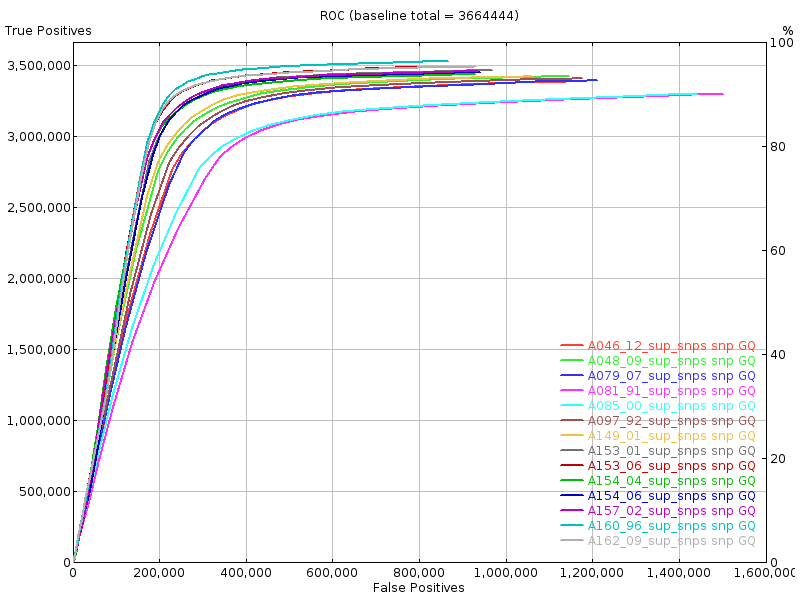

- **Indels**
  - Precision: 0.618 ± 0.049 (median: 0.628)
  - Sensitivity: 0.544 ± 0.048 (median: 0.556)
  - F-measure: 0.579 ± 0.049 (median: 0.590)

For indels, the performance is lower across all metrics compared to SNPs. Sensitivity is particularly lower, suggesting that the method misses a notable portion of true indels. However, the ROC curves for indels are below the diagonal, which might indicate the Illumina indel dataset used as the truth set is not a good reference, possibly due to mislabelling or an incomplete representation of true indel variants.

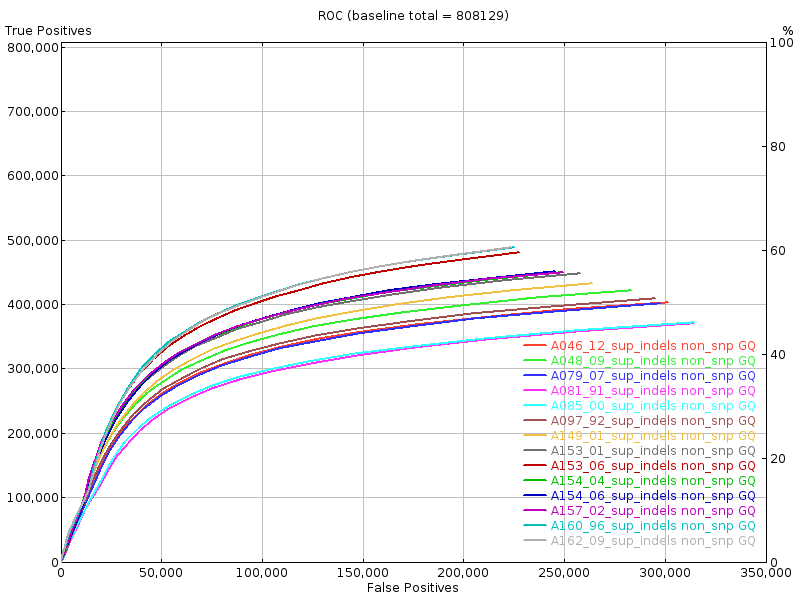

#### 2. Impact of multiplexing on variant calling

Basecalling algorithm: `sup`

- **SNPs (Multiplexed)**

  - Precision: 0.727±0.026 (median: 0.741)
  - Sensitivity: 0.932±0.016 (median: 0.938)
  - F-measure: 0.817±0.022 (median: 0.828)

- **SNPs (Singleplexed)**

  - Precision: 0.788±0.012 (median: 0.788)
  - Sensitivity: 0.959±0.003 (median: 0.960)
  - F-measure: 0.865±0.008 (median: 0.865)


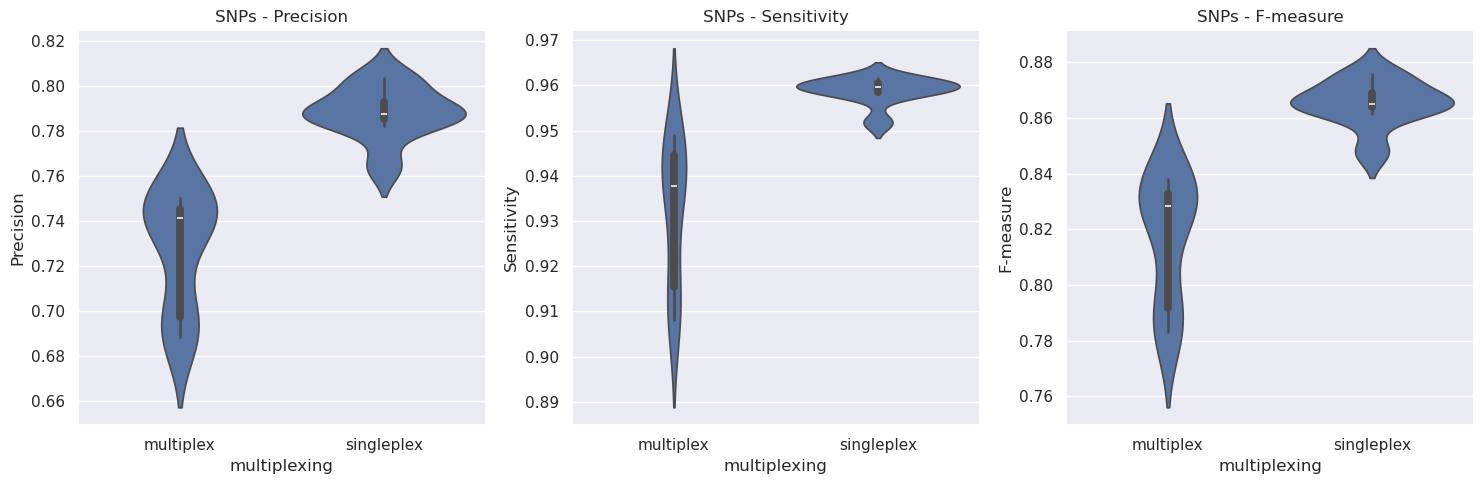

In [66]:
sup_data = merged_df[merged_df["basecall"] == "sup"]

snps_data = sup_data[sup_data["variant_type"] == "snps"]
indels_data = sup_data[sup_data["variant_type"] == "indels"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.violinplot(x="multiplexing", y="Precision", data=snps_data)
plt.title("SNPs - Precision")
plt.subplot(1, 3, 2)
sns.violinplot(x="multiplexing", y="Sensitivity", data=snps_data)
plt.title("SNPs - Sensitivity")
plt.subplot(1, 3, 3)
sns.violinplot(x="multiplexing", y="F-measure", data=snps_data)
plt.title("SNPs - F-measure")

plt.tight_layout()
plt.show()


- **Indels (Multiplexed)**

  - Precision: 0.568±0.022 (median: 0.573)
  - Sensitivity: 0.497±0.028 (median: 0.503)
  - F-measure: 0.530±0.025 (median: 0.536)

- **Indels (Singleplexed)**

  - Precision: 0.655±0.024 (median: 0.646)
  - Sensitivity: 0.579±0.022 (median: 0.570)
  - F-measure: 0.615±0.023 (median: 0.606)


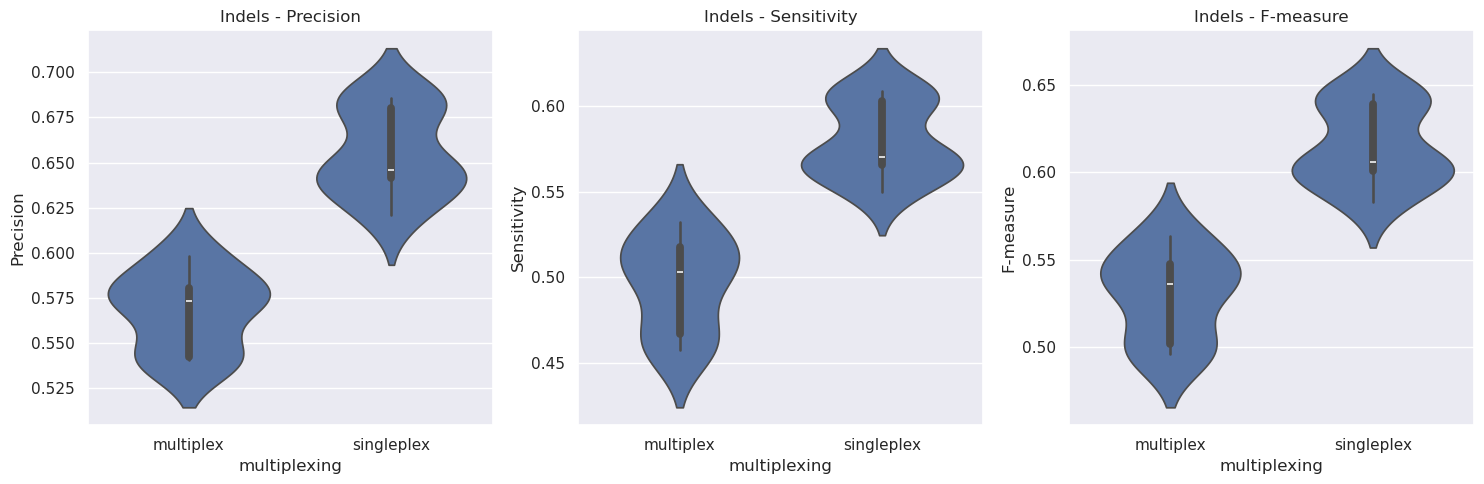

In [67]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.violinplot(x="multiplexing", y="Precision", data=indels_data)
plt.title("Indels - Precision")
plt.subplot(1, 3, 2)
sns.violinplot(x="multiplexing", y="Sensitivity", data=indels_data)
plt.title("Indels - Sensitivity")
plt.subplot(1, 3, 3)
sns.violinplot(x="multiplexing", y="F-measure", data=indels_data)
plt.title("Indels - F-measure")

plt.tight_layout()
plt.show()


In [68]:
singleplex_snps = final_grouped[
    (final_grouped["multiplexing"] == "singleplex")
    & (final_grouped["variant_type"] == "snps")
]
multiplex_snps = final_grouped[
    (final_grouped["multiplexing"] == "multiplex")
    & (final_grouped["variant_type"] == "snps")
]

singleplex_indels = final_grouped[
    (final_grouped["multiplexing"] == "singleplex")
    & (final_grouped["variant_type"] == "indels")
]
multiplex_indels = final_grouped[
    (final_grouped["multiplexing"] == "multiplex")
    & (final_grouped["variant_type"] == "indels")
]


def calculate_percentage_increase(singleplex_mean, multiplex_mean):
    return ((singleplex_mean - multiplex_mean) / multiplex_mean) * 100


snps_precision_increase = calculate_percentage_increase(
    singleplex_snps["Precision_mean"].values[0],
    multiplex_snps["Precision_mean"].values[0],
)
snps_sensitivity_increase = calculate_percentage_increase(
    singleplex_snps["Sensitivity_mean"].values[0],
    multiplex_snps["Sensitivity_mean"].values[0],
)
snps_fmeasure_increase = calculate_percentage_increase(
    singleplex_snps["F-measure_mean"].values[0],
    multiplex_snps["F-measure_mean"].values[0],
)

indels_precision_increase = calculate_percentage_increase(
    singleplex_indels["Precision_mean"].values[0],
    multiplex_indels["Precision_mean"].values[0],
)
indels_sensitivity_increase = calculate_percentage_increase(
    singleplex_indels["Sensitivity_mean"].values[0],
    multiplex_indels["Sensitivity_mean"].values[0],
)
indels_fmeasure_increase = calculate_percentage_increase(
    singleplex_indels["F-measure_mean"].values[0],
    multiplex_indels["F-measure_mean"].values[0],
)

print(
    f"- Precision: There is a {snps_precision_increase:.2f}% increase in mean precision for singleplexed SNPs samples."
)
print(
    f"- Sensitivity: There is a {snps_sensitivity_increase:.2f}% increase in mean sensitivity for singleplexed SNPs samples."
)
print(
    f"- F-measure: There is a {snps_fmeasure_increase:.2f}% increase in mean F-measure for singleplexed SNPs samples.\n"
)
print(
    f"- Precision: There is a {indels_precision_increase:.2f}% increase in mean precision for singleplexed indels samples."
)
print(
    f"- Sensitivity: There is a {indels_sensitivity_increase:.2f}% increase in mean sensitivity for singleplexed indels samples."
)
print(
    f"- F-measure: There is a {indels_fmeasure_increase:.2f}% increase in mean F-measure for singleplexed indels samples."
)


- Precision: There is a 13.61% increase in mean precision for singleplexed SNPs samples.
- Sensitivity: There is a 4.03% increase in mean sensitivity for singleplexed SNPs samples.
- F-measure: There is a 9.38% increase in mean F-measure for singleplexed SNPs samples.

- Precision: There is a 18.20% increase in mean precision for singleplexed indels samples.
- Sensitivity: There is a 22.25% increase in mean sensitivity for singleplexed indels samples.
- F-measure: There is a 20.37% increase in mean F-measure for singleplexed indels samples.


#### 3. Impact of basecalling algorithms on variant calling

- **SNPs (Basecall HAC)**

  - Precision: 0.731 ± 0.055 (median: 0.753)
  - Sensitivity: 0.945 ± 0.023 (median: 0.956)
  - F-measure: 0.824 ± 0.044 (median: 0.843)

- **SNPs (Basecall SUP)**

  - Precision: 0.762 ± 0.036 (median: 0.773)
  - Sensitivity: 0.947 ± 0.017 (median: 0.955)
  - F-measure: 0.844 ± 0.029 (median: 0.855)

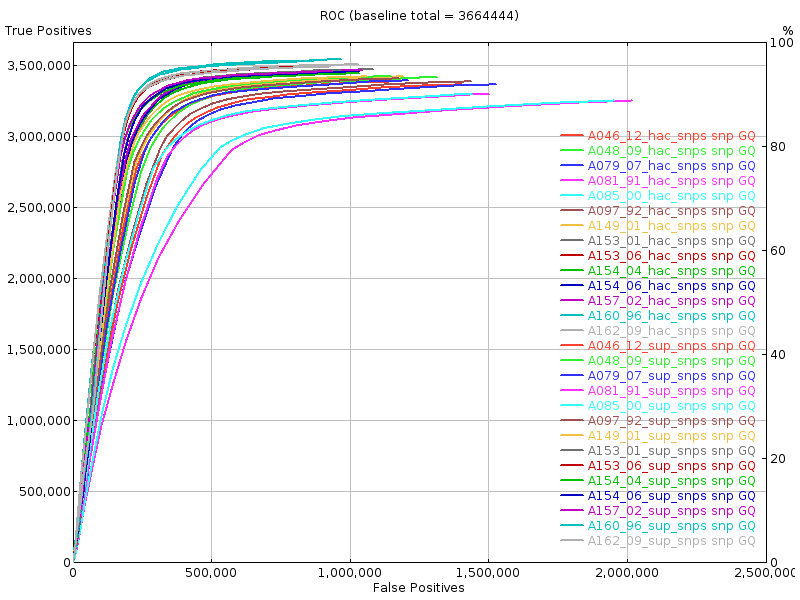


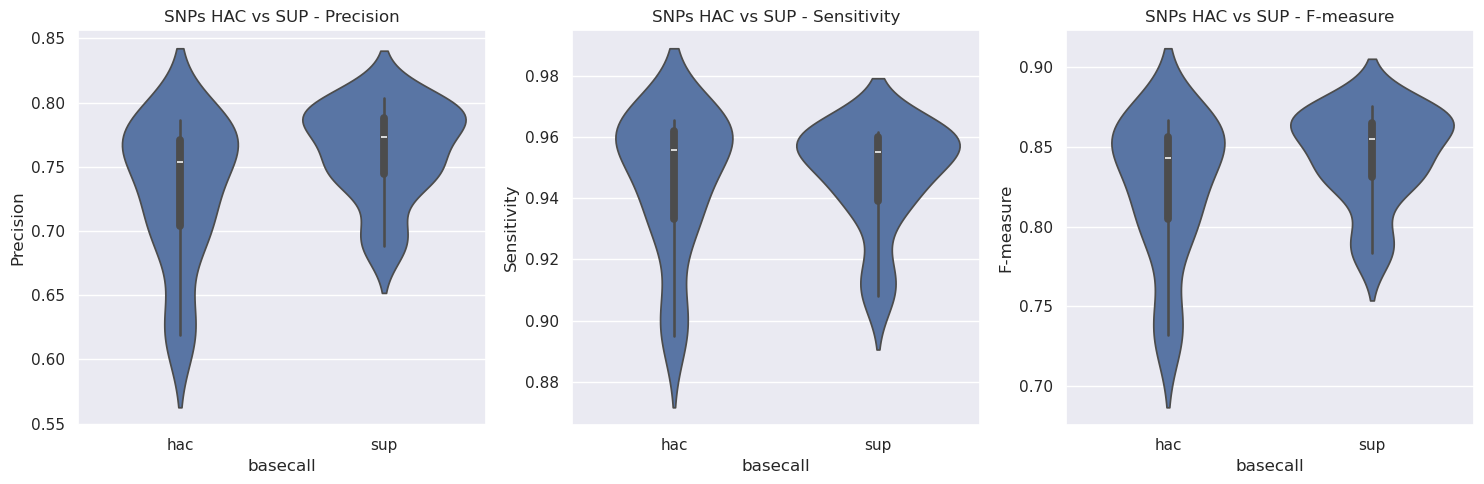

In [69]:
snps_df = merged_df[merged_df["variant_type"] == "snps"]
indels_df = merged_df[merged_df["variant_type"] == "indels"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.violinplot(x="basecall", y="Precision", data=snps_df)
plt.title("SNPs HAC vs SUP - Precision")

plt.subplot(1, 3, 2)
sns.violinplot(x="basecall", y="Sensitivity", data=snps_df)
plt.title("SNPs HAC vs SUP - Sensitivity")

plt.subplot(1, 3, 3)
sns.violinplot(x="basecall", y="F-measure", data=snps_df)
plt.title("SNPs HAC vs SUP - F-measure")

plt.tight_layout()
plt.show()


- **Indels (Basecall HAC)**

  - Precision: 0.574 ± 0.054 (median: 0.584)
  - Sensitivity: 0.500 ± 0.057 (median: 0.517)
  - F-measure: 0.534 ± 0.056 (median: 0.548)

- **Indels (Basecall SUP)**

  - Precision: 0.618 ± 0.049 (median: 0.628)
  - Sensitivity: 0.544 ± 0.048 (median: 0.556)
  - F-measure: 0.579 ± 0.049 (median: 0.590)

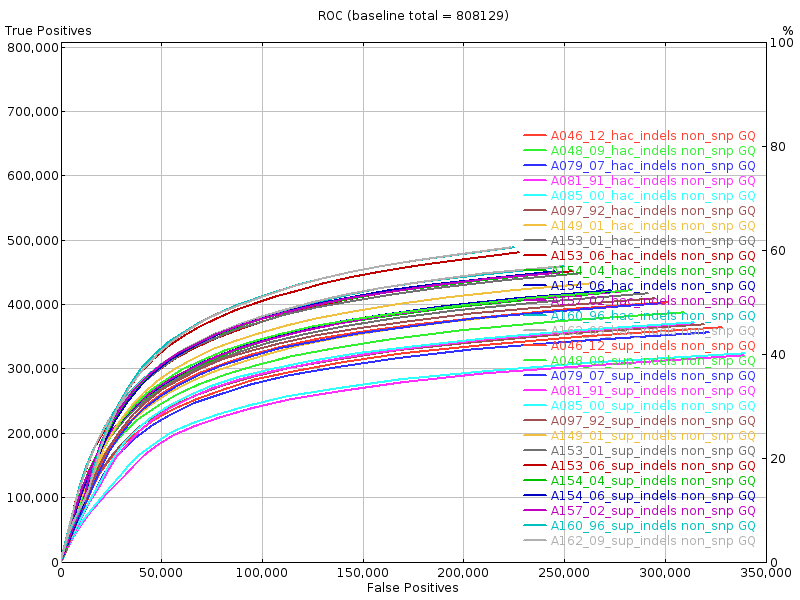


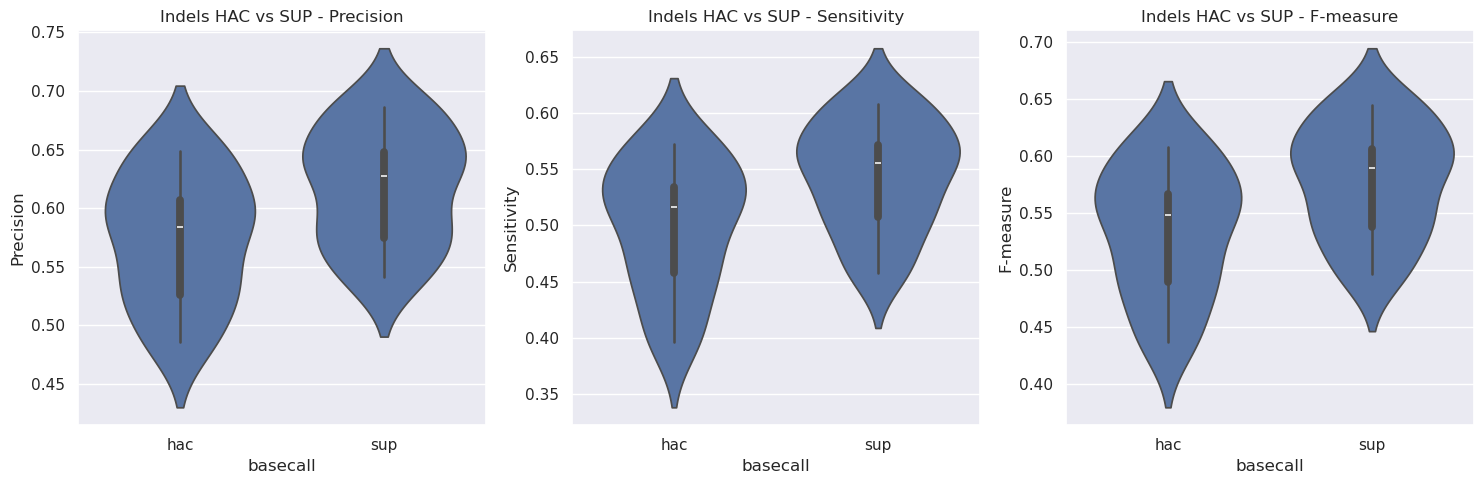

In [70]:
plt.figure(figsize=(15, 5))

order = ["hac", "sup"]

plt.subplot(1, 3, 1)
sns.violinplot(x="basecall", y="Precision", data=indels_df, order=order)
plt.title("Indels HAC vs SUP - Precision")

plt.subplot(1, 3, 2)
sns.violinplot(x="basecall", y="Sensitivity", data=indels_df, order=order)
plt.title("Indels HAC vs SUP - Sensitivity")

plt.subplot(1, 3, 3)
sns.violinplot(x="basecall", y="F-measure", data=indels_df, order=order)
plt.title("Indels HAC vs SUP - F-measure")

plt.tight_layout()
plt.show()


In [71]:
hac_snps = final_grouped[
    (final_grouped["basecall"] == "hac") & (final_grouped["variant_type"] == "snps")
]
sup_snps = final_grouped[
    (final_grouped["basecall"] == "sup") & (final_grouped["variant_type"] == "snps")
]

hac_indels = final_grouped[
    (final_grouped["basecall"] == "hac") & (final_grouped["variant_type"] == "indels")
]
sup_indels = final_grouped[
    (final_grouped["basecall"] == "sup") & (final_grouped["variant_type"] == "indels")
]


def calculate_percentage_increase(hac_mean, sup_mean):
    return ((sup_mean - hac_mean) / hac_mean) * 100


snps_precision_increase = calculate_percentage_increase(
    hac_snps["Precision_mean"].values[0], sup_snps["Precision_mean"].values[0]
)
snps_sensitivity_increase = calculate_percentage_increase(
    hac_snps["Sensitivity_mean"].values[0], sup_snps["Sensitivity_mean"].values[0]
)
snps_fmeasure_increase = calculate_percentage_increase(
    hac_snps["F-measure_mean"].values[0], sup_snps["F-measure_mean"].values[0]
)

indels_precision_increase = calculate_percentage_increase(
    hac_indels["Precision_mean"].values[0], sup_indels["Precision_mean"].values[0]
)
indels_sensitivity_increase = calculate_percentage_increase(
    hac_indels["Sensitivity_mean"].values[0], sup_indels["Sensitivity_mean"].values[0]
)
indels_fmeasure_increase = calculate_percentage_increase(
    hac_indels["F-measure_mean"].values[0], sup_indels["F-measure_mean"].values[0]
)

print(
    f"- Precision: There is a {snps_precision_increase:.2f}% increase in mean precision for SUP SNPs samples compared to HAC SNPs samples."
)
print(
    f"- Sensitivity: There is a {snps_sensitivity_increase:.2f}% increase in mean sensitivity for SUP SNPs samples compared to HAC SNPs samples."
)
print(
    f"- F-measure: There is a {snps_fmeasure_increase:.2f}% increase in mean F-measure for SUP SNPs samples compared to HAC SNPs samples.\n"
)
print(
    f"- Precision: There is a {indels_precision_increase:.2f}% increase in mean precision for SUP Indels samples compared to HAC Indels samples."
)
print(
    f"- Sensitivity: There is a {indels_sensitivity_increase:.2f}% increase in mean sensitivity for SUP Indels samples compared to HAC Indels samples."
)
print(
    f"- F-measure: There is a {indels_fmeasure_increase:.2f}% increase in mean F-measure for SUP Indels samples compared to HAC Indels samples."
)


- Precision: There is a 7.25% increase in mean precision for SUP SNPs samples compared to HAC SNPs samples.
- Sensitivity: There is a 0.85% increase in mean sensitivity for SUP SNPs samples compared to HAC SNPs samples.
- F-measure: There is a 4.48% increase in mean F-measure for SUP SNPs samples compared to HAC SNPs samples.

- Precision: There is a 9.37% increase in mean precision for SUP Indels samples compared to HAC Indels samples.
- Sensitivity: There is a 12.09% increase in mean sensitivity for SUP Indels samples compared to HAC Indels samples.
- F-measure: There is a 10.83% increase in mean F-measure for SUP Indels samples compared to HAC Indels samples.
